In [22]:
import pandas as pd
import numpy as np
import random
import string
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer

import collections
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
from sklearn.metrics import f1_score

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.base import BaseEstimator
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.layers import Bidirectional
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.callbacks import TensorBoard



tqdm.pandas()
%matplotlib inline

/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
train = pd.read_csv('../data/nlp_tweet_data/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.shape

(7613, 5)

In [4]:
#train = train.drop(['id','keyword','location'],axis=1)

In [5]:
test = pd.read_csv('../data/nlp_tweet_data/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
class_indexes = list(train['target'].value_counts().index)

In [8]:
df = train.append(test)

## Preprocess

In [9]:
 def clean_text(text, remove_stopwords=True, stem_words=False, lemma=True):
    # Clean the text, with the option to remove stopwords and to stem words.

        text = str(text).lower().split()

        # Optionally, remove stop words
#         if remove_stopwords:
#             stops = set(stopwords.words("english"))
#             text = [w for w in text if not w in stops]

        text = " ".join(text)
        
        # remove URLs
        url = re.compile(r'https?://\S+|www\.\S+')
        text = url.sub(r'',text)
        
        # remove html tags
        text = re.sub(r'<.*?>', "", text)
        
        # remove emoji
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        
        
        text = emoji_pattern.sub(r'', text)
        
        # remove punctuation from text
        text  = "".join([char for char in text if char not in string.punctuation])

        # Clean the text
        text = re.sub(r"[-()\"#/<>!@&;*:<>{}`'+=~%|.!?,_]", " ", text)
        text = re.sub(r"\]", " ", text)
        text = re.sub(r"\[", " ", text)
        text = re.sub(r"\/", " ", text)
        text = re.sub(r"\\", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"  ", " ", text)
        text = re.sub(r"   ", " ", text)
        text = re.sub(r"   ", " ", text)
        text = re.sub(r"0x00", "", text)
        
        

        # Optionally, shorten words to their stems
        if stem_words:
            text = text.split()
            stemmer = SnowballStemmer('english')
            stemmed_words = [stemmer.stem(word) for word in text]
            text = " ".join(stemmed_words)

        if lemma:
            text = text.split()
            lem = WordNetLemmatizer()
            lemmatized = [lem.lemmatize(word,"v") for word in text]
            text = " ".join(lemmatized)

        # Return a list of words
        return(text)

In [10]:
df['text'] = df['text'].progress_apply(lambda x:clean_text(x))

100%|██████████| 10876/10876 [00:02<00:00, 4518.90it/s]


In [11]:
train['text'] = train['text'].progress_apply(lambda x:clean_text(x))

100%|██████████| 7613/7613 [00:00<00:00, 12018.59it/s]


In [12]:
test['text'] = test['text'].progress_apply(lambda x:clean_text(x))

100%|██████████| 3263/3263 [00:00<00:00, 11026.70it/s]


## Tfidf vectorizer

In [13]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1000)
tfidf_vect.fit(df['text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

## Top n word from every class

In [19]:
Xtr = tfidf_vect.fit_transform(train['text'])

In [20]:
features = tfidf_vect.get_feature_names()
y = np.array(train['target'])

In [21]:
def top_tfidf_feats(row, features, top_n=50):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [22]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=50):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [23]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=50):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [24]:
top_dfs=top_feats_by_class(Xtr, y, features)

In [25]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 14), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=8)
        ax.set_title("label = " + str(df.label), fontsize=8)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

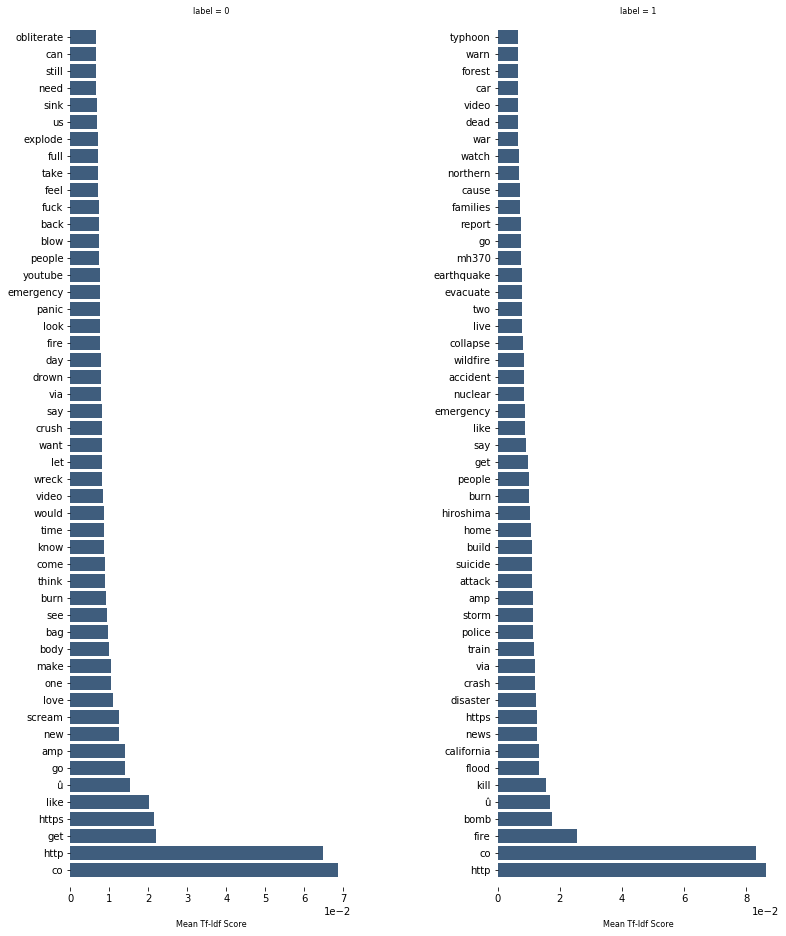

In [26]:
plot_tfidf_classfeats_h(top_dfs)

In [30]:
not_real = list(top_dfs[0]['feature'])
not_real

['co',
 'http',
 'get',
 'https',
 'like',
 'û',
 'go',
 'amp',
 'new',
 'scream',
 'love',
 'one',
 'make',
 'body',
 'bag',
 'see',
 'burn',
 'think',
 'come',
 'know',
 'time',
 'would',
 'video',
 'wreck',
 'let',
 'want',
 'crush',
 'say',
 'via',
 'drown',
 'day',
 'fire',
 'look',
 'panic',
 'emergency',
 'youtube',
 'people',
 'blow',
 'back',
 'fuck',
 'feel',
 'take',
 'full',
 'explode',
 'us',
 'sink',
 'need',
 'still',
 'can',
 'obliterate']

In [31]:
not_real = top_dfs[0]['feature'].tolist()
real = top_dfs[1]['feature'].tolist()
total_common = [x for x in not_real if x in real]
print("total common: ", len(total_common))
print("commons: \n",total_common)

total common:  15
commons: 
 ['co', 'http', 'get', 'https', 'like', 'û', 'go', 'amp', 'burn', 'video', 'say', 'via', 'fire', 'emergency', 'people']


## manual features

In [16]:
train_text_lengths = np.array(list(map(len, train.text.str.split(' '))))
test_text_lengths = np.array(list(map(len, test.text.str.split(' '))))

## Train Test split

In [14]:
train_new=df[:train.shape[0]]
test_new=df[train.shape[0]:]

In [15]:
# transform the training and validation data using count vectorizer object
train_tfidf =  tfidf_vect.transform(train['text'])
test_tfidf =  tfidf_vect.transform(test['text'])

In [17]:
# convert tfidf to dataframe
train_tfidf_df = pd.DataFrame(train_tfidf.toarray())
train_tfidf_df['length'] = list(train_text_lengths)
train_tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16


In [18]:
test_tfidf_df = pd.DataFrame(test_tfidf.toarray())
test_tfidf_df['length'] = list(test_text_lengths)
test_tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8


In [19]:
x_train, x_test, y_train, y_test = train_test_split(train_tfidf_df, train['target'])
print('train shape: ',x_train.shape)
print('test shape: ',x_test.shape)

train shape:  (5709, 1001)
test shape:  (1904, 1001)


In [20]:
print("train_y label count: ",collections.Counter(y_train))
print("valid_y label count: ",collections.Counter(y_test))

train_y label count:  Counter({0: 3226, 1: 2483})
valid_y label count:  Counter({0: 1116, 1: 788})


## Basic ML models

In [23]:
class MyClassifier(BaseEstimator):

    def __init__(self, classifier_type):
        """
        A Custome BaseEstimator that can switch between classifiers.
        :param classifier_type: string - The switch for different classifiers
        """
        self.classifier_type = classifier_type


    def fit(self, X, y=None):
        if self.classifier_type == 'LDA':
            self.classifier_ = LinearDiscriminantAnalysis(solver='svd')
        elif self.classifier_type == 'Logistic Regression':
            self.classifier_ = LogisticRegression(C=1.0, dual= False, max_iter=500,penalty = 'l2' , 
                                                  solver = 'liblinear', class_weight='balanced', 
                                                  multi_class='ovr', random_state=42, tol=1e-05)
        elif self.classifier_type == 'LinSVC':
            self.classifier_ = svm.LinearSVC(C=1.0, dual= False, fit_intercept=True,
     intercept_scaling =0.1, max_iter=1000,penalty = 'l2' , loss = 'squared_hinge', class_weight='balanced',
     multi_class='ovr', random_state=42, tol=1e-05, verbose=0)
        elif self.classifier_type == 'Random Forest':
            self.classifier_ = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
        elif self.classifier_type == 'Decision Tree':
            self.classifier_ = DecisionTreeClassifier()
        elif self.classifier_type == 'Gradient boost':
            self.classifier_ = GradientBoostingClassifier(n_estimators=50)
        else:
            raise ValueError('Unkown classifier type.')
        self.classifier_.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.classifier_.predict(X)
    

In [24]:
def performance_plots(y_test_sample, y_pred, ml_algo):
    print("---------"+ml_algo+"-----------")
    acc = metrics.accuracy_score(y_pred, y_test_sample)
    print("Accuracy: ",acc)
    f1_val = f1_score(y_test_sample, y_pred)
    print("F1-Score: ",f1_val)
    print("NORMALISED CM  for Tag6")
    cm = confusion_matrix(y_test_sample,y_pred)
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    ind = class_indexes
    cols = class_indexes
    cm_df = pd.DataFrame(norm_cm,cols,ind)
    plt.figure(figsize=(22,10)) 
    sns.heatmap(cm_df, annot=True,cmap = "Greens",fmt='g')
    print(classification_report(y_test_sample,y_pred))
    print(accuracy_score(y_test_sample, y_pred))
    return

### LDA

In [25]:
lda_model = MyClassifier('LDA')
lda_model.fit(x_train, y_train)
lda_pred = lda_model.predict(x_test)

---------LDA-----------
Accuracy:  0.7783613445378151
F1-Score:  0.7280927835051547
NORMALISED CM  for Tag6
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1116
           1       0.74      0.72      0.73       788

    accuracy                           0.78      1904
   macro avg       0.77      0.77      0.77      1904
weighted avg       0.78      0.78      0.78      1904

0.7783613445378151


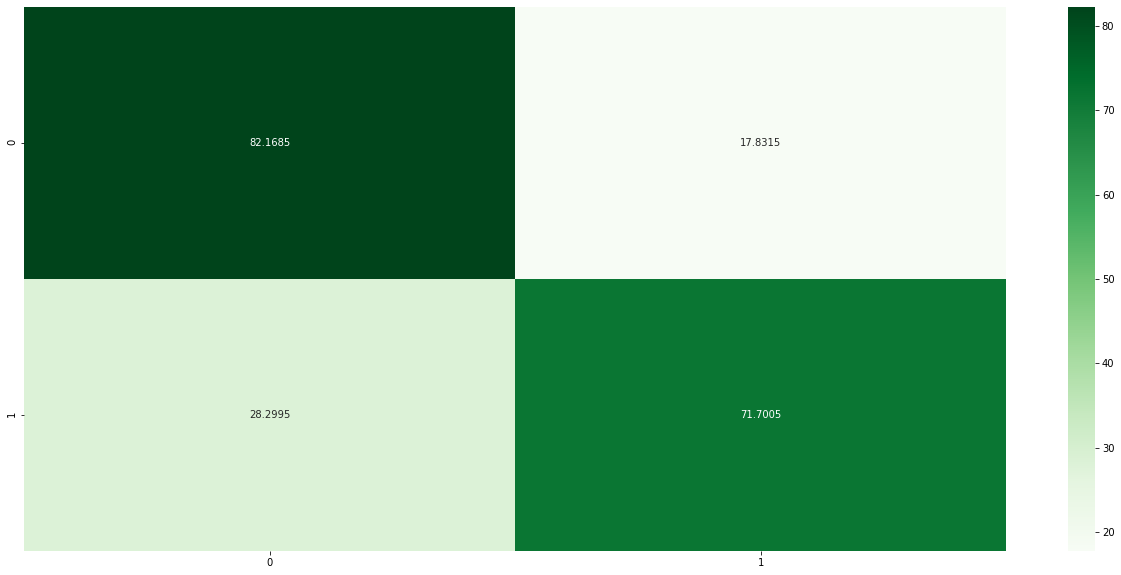

In [26]:
performance_plots(y_test, lda_pred, 'LDA')

### Logistic Regression

In [27]:
logistic_model = MyClassifier('Logistic Regression')
logistic_model.fit(x_train, y_train)
logistic_pred = logistic_model.predict(x_test)

---------Logistic Regression-----------
Accuracy:  0.789390756302521
F1-Score:  0.7517027863777089
NORMALISED CM  for Tag6
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1116
           1       0.73      0.77      0.75       788

    accuracy                           0.79      1904
   macro avg       0.78      0.79      0.78      1904
weighted avg       0.79      0.79      0.79      1904

0.789390756302521


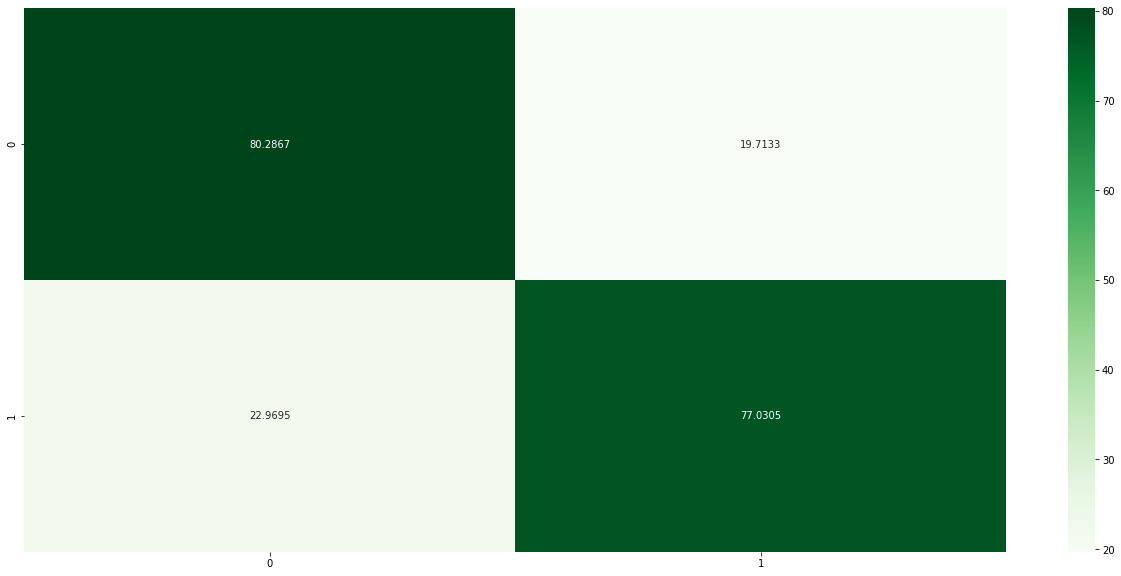

In [28]:
performance_plots(y_test, logistic_pred, 'Logistic Regression')

### SVM linear

In [31]:
svm_model = MyClassifier('LinSVC')
svm_model.fit(x_train, y_train)
svm_pred = svm_model.predict(x_test)

---------LinSVC-----------
Accuracy:  0.7668067226890757
F1-Score:  0.7286063569682153
NORMALISED CM  for Tag6
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1116
           1       0.70      0.76      0.73       788

    accuracy                           0.77      1904
   macro avg       0.76      0.77      0.76      1904
weighted avg       0.77      0.77      0.77      1904

0.7668067226890757


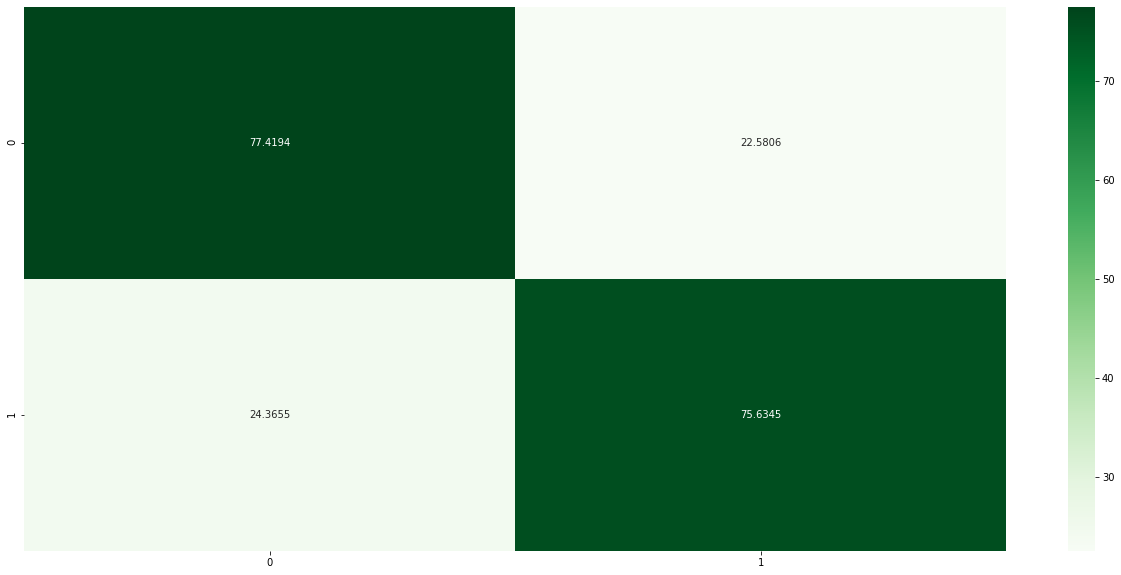

In [32]:
performance_plots(y_test, svm_pred, 'LinSVC')

### Random Forest

In [28]:
rf_model = MyClassifier('Random Forest')
rf_model.fit(xtrain_tfidf, y_train)
rf_pred = rf_model.predict(xtest_tfidf)

---------Random Forest-----------
Accuracy:  0.7809873949579832
NORMALISED CM  for Tag6
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1104
           1       0.78      0.67      0.72       800

    accuracy                           0.78      1904
   macro avg       0.78      0.77      0.77      1904
weighted avg       0.78      0.78      0.78      1904

0.7809873949579832


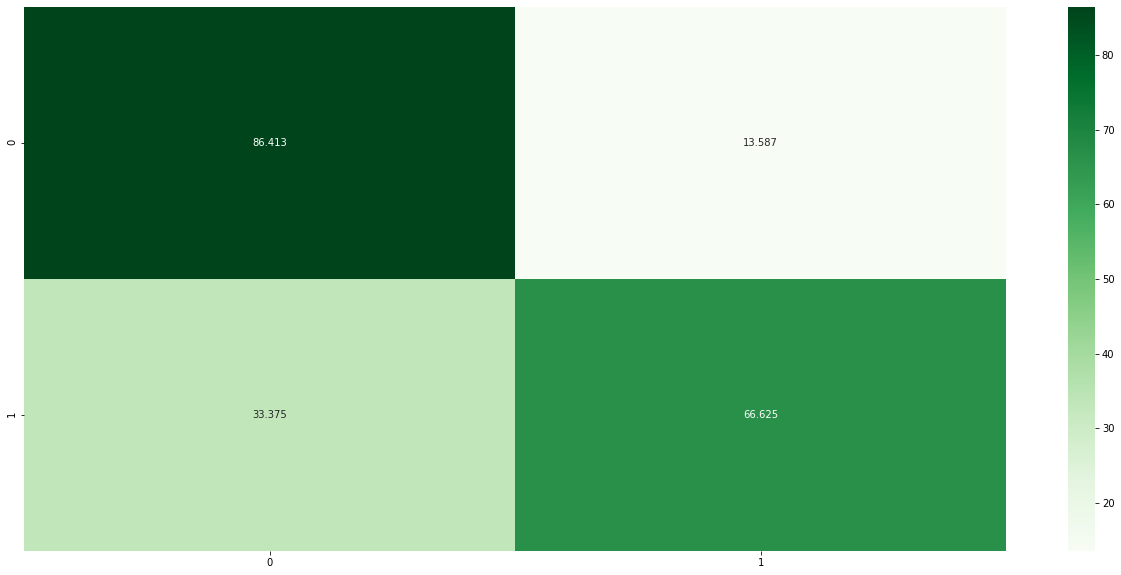

In [29]:
performance_plots(y_test, rf_pred, 'Random Forest')

### Gradient boost

In [30]:
gb_model = MyClassifier('Gradient boost')
gb_model.fit(xtrain_tfidf, y_train)
gb_pred = gb_model.predict(xtest_tfidf)

---------Gradient boost-----------
Accuracy:  0.7316176470588235
NORMALISED CM  for Tag6
              precision    recall  f1-score   support

           0       0.73      0.87      0.79      1104
           1       0.75      0.55      0.63       800

    accuracy                           0.73      1904
   macro avg       0.74      0.71      0.71      1904
weighted avg       0.73      0.73      0.72      1904

0.7316176470588235


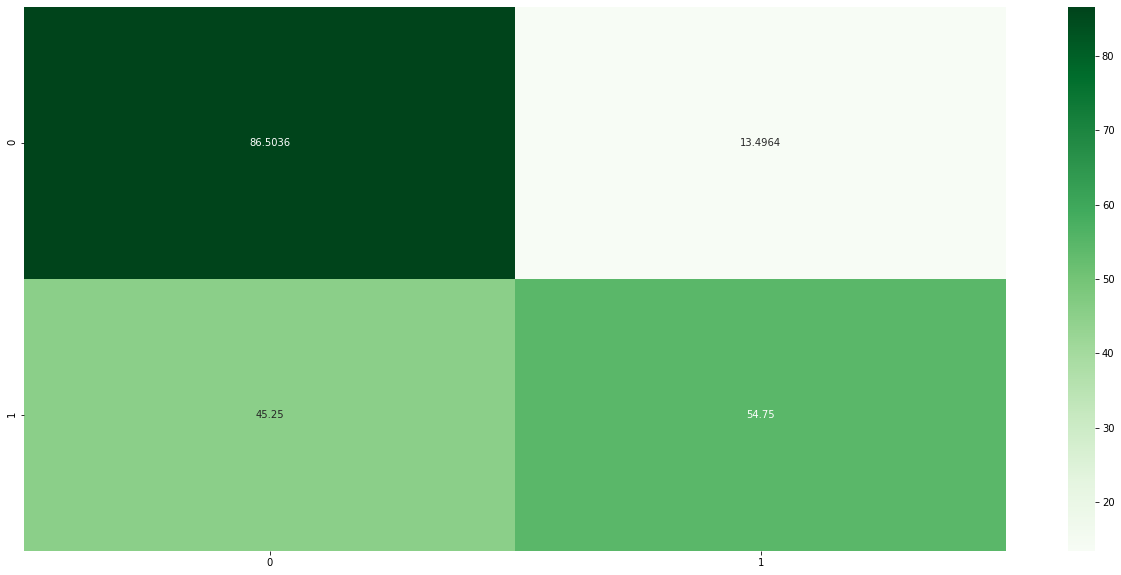

In [31]:
performance_plots(y_test, gb_pred, 'Gradient boost')

In [32]:
train['text'].head(20)

0          deeds reason earthquake may allah forgive us
1                 forest fire near la ronge sask canada
2     residents ask shelter place notify officer eva...
3     people receive wildfires evacuation order cali...
4     get send photo ruby alaska smoke wildfires pou...
5     rockyfire update california hwy close directio...
6     flood disaster heavy rain cause flash flood st...
7                               top hill see fire woods
8     there emergency evacuation happen build across...
9                              afraid tornado come area
10                       three people die heat wave far
11    haha south tampa get flood hah wait second liv...
12    rain flood florida tampabay tampa days ve lose...
13                    flood bago myanmar we arrive bago
14              damage school bus multi car crash break
15                                             what man
16                                           love fruit
17                                        summer